# House Prices Kaggle Competition


## Authors 
David Moreno Maldonado 100441714    
Inés Fernández Campos 100443936    

## Assignment

For the completion of this exercise we start by importing all the libraries we are going to need as well as defining all parameters for the assignment.

In [1]:
import pandas as pd
import numpy as np
import sys
import time
import math
import statistics as st
from sklearn import preprocessing, model_selection, tree, neighbors, metrics
from scipy.stats import uniform, randint as sp_randint
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
import optuna
import optuna.visualization as ov

In [3]:
#MAIN PARAMETERS FOR THE ASSIGNMENT
budget = 50
random_state = 0
verbose = 1

#PARAMETERS FOR THE HYPER-PARAMETER TUNNING
min_max_depth = 2
max_max_depth = 20
min_n_neigbors = 1
max_n_neigbors = 16

We also create a dataframe that will contain all information regarding the studied models for each different configuration applied.

In [4]:
#Dataframes with all the information of each model
summary = {
    'tree': pd.DataFrame(columns=['Time (sec)', 'Score (RMSE)', 'Min. samples split', 'Criterion', 'Max. depth']),
    'knn': pd.DataFrame(columns=['Time (sec)', 'Score (RMSE)', 'N. neighbors', 'Weights', 'P'])
}

### Loading data

In the next cells we load the data, split it in four matrices, two used for training and two used for the competition, we standardize the input attributes and split our training matrices into train test splits, as well as define the cross validation grid used for 2-fold cross validation throughout the exercise.

In [5]:
#Loading data
data = pd.read_csv("kaggleCompetition.csv")
data = data.values

#Splitting data in the one used for training and the one used for the competition
x = data[0:1460, :-1]
y = data[0:1460, -1] 
x_comp = data[1460:,:-1] 
y_comp = data[1460:,-1]

In [6]:
#Standardize input attributes.
scaler = preprocessing.StandardScaler().fit(x) 
x = scaler.transform(x)
x_comp = scaler.transform(x_comp)

In [7]:
#Split in train/test sets using holdout 3/4 for training, 1/4 for testing
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, train_size=0.75, random_state=0)

#Hyperparams evaluated by 2-fold CV (inner evaluation)
cv_grid = model_selection.KFold(n_splits=2, shuffle=True, random_state=random_state)

### Training models using **default parameters**

In this section we evaluate the performance of the regression using decission trees and KNN when using default parameters.

We start by training the decision tree with all its default parameters: min_samples_split = 2, max_depth = None and criterion='mse'.    
Once trained, we perform its inner evaluation applying 2-fold CV on the train splitted data and save the acquired data to our summary dataframe.

In [8]:
#3.1.1 Decision Tree
np.random.seed(random_state)
tree_default = tree.DecisionTreeRegressor(random_state=random_state)

scores = -model_selection.cross_val_score(tree_default, x_train, y_train, scoring='neg_root_mean_squared_error', cv=cv_grid)

summary['tree'] = summary['tree'].append(pd.Series({
    'Time (sec)': 0, 
    'Score (RMSE)': scores.mean(),
    'Min. samples split': 2, 
    'Criterion': 'mse', 
    'Max. depth': 'None'
    },
    name='default'))

We also implement regression through KNN with all its default parameters: n_neighbors=5, weights='uniform', p=2, metric='minkowski'.   
As we did with the decision tree, once trained, we perform its inner evaluation applying 2-fold CV on the train splitted data and save the acquired data to our summary dataframe.

In [9]:
#3.1.2 K Nearest neighbours
np.random.seed(random_state)
knn_default = neighbors.KNeighborsRegressor()
scores = -model_selection.cross_val_score(knn_default, x_train, y_train, scoring='neg_root_mean_squared_error', cv=cv_grid) 

summary['knn'] = summary['knn'].append(pd.Series({
    'Time (sec)': 0, 
    'Score (RMSE)': scores.mean(), 
    'N. neighbors': 5, 
    'Weights': 'uniform', 
    'P': 2
    }, 
    name='default'))

### Training models using **Random Search** tuning

In this section we evaluate the performance of the regression using decission trees and KNN when using random search to tune the hyper-parameters.

Since now we are using random search to tune our hyper-parameters, we must first define our hyper-parameter search space, in this case, *param_grid*.   
For decision trees this greed hold three hyper-parameters to tune: the min_samples_split, a set of real numbers within 0.0 and 1.0, the criterion, either mse of friedman_mse, and finally the max_depth wich will be an integer between 2 and 20.   

Once the search space defined, we define the two step method to be applied on the decision tree and evaluated using 2-fold CV over *budget* (20) iterations and performance measure the negative root MSE.      
Then, the two step method is trained and timed and the best values for the hyper-parameters along with the time are saved in the correspondant summary dataframe.

In [10]:
###3.2 Random search for Decission Tree hyper-parameter tunning
np.random.seed(random_state)
param_grid = {
    'min_samples_split': uniform(0, 1),
    'criterion': ['mse','friedman_mse'], 
    'max_depth': sp_randint(min_max_depth, max_max_depth)
}
tree_random_search = model_selection.RandomizedSearchCV(
    tree.DecisionTreeRegressor(random_state=random_state), 
    param_grid,
    scoring='neg_root_mean_squared_error',
    cv=cv_grid, 
    verbose=verbose,
    n_iter=budget
    )
start_time = time.time()
tree_random_search.fit(X=x_train, y=y_train)
end_time = time.time()

summary['tree'] = summary['tree'].append(pd.Series({
    'Time (sec)': '{:.4f}'.format(end_time - start_time), 
    'Score (RMSE)': -tree_random_search.best_score_,
    'Min. samples split': tree_random_search.best_params_['min_samples_split'], 
    'Criterion': tree_random_search.best_params_['criterion'], 
    'Max. depth': tree_random_search.best_params_['max_depth']
    },
    name='random_search'))

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


For KNN, the procedure is the same, the only thing that changes is the hyper-parameters to tune. In this case, these are: the number of neighbors, a random integer between 1 and 16, the weights, the type of distance, and p, the exponent of the distance.

In [11]:
###3.3 Random search for K Nearest Neighbours hyper-parameter tunning
np.random.seed(random_state)
param_grid = {
    'n_neighbors': sp_randint(min_n_neigbors, max_n_neigbors),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

knn_random_search = model_selection.RandomizedSearchCV(
    neighbors.KNeighborsRegressor(), 
    param_grid,
    scoring='neg_root_mean_squared_error',
    cv=cv_grid, 
    verbose=verbose,
    n_iter=budget
    )
start_time = time.time()
knn_random_search.fit(X=x_train, y=y_train)
end_time = time.time()

summary['knn'] = summary['knn'].append(pd.Series({
    'Time (sec)': '{:.4f}'.format(end_time - start_time), 
    'Score (RMSE)': -knn_random_search.best_score_, 
    'N. neighbors': knn_random_search.best_params_['n_neighbors'], 
    'Weights': knn_random_search.best_params_['weights'], 
    'P': knn_random_search.best_params_['p']
    }, 
    name='random_search'))

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.9s finished


### Training models using **SKOPT - Bayesian Optimization** Hyper-Parameter tuning

The following section goes through the implementation of hyper-parameter tuning by means of model based optimization (bayesian optimization).    

In comparison with the previous search methods, the implementation of Bayesian optimization is very similar in the sense that we define a similar parameter grid with the hyper-parameters to explore, evaluate with 2-fold CV and measure performance through the negative root MSE.    
Differences can be found however, in the way the search space of the hyper-parameters are defined, in this case using specific skopt classes that stablish the hyper-parameter's type.

In [12]:
#3.4.1 Decission trees
np.random.seed(random_state)
param_grid = {
    'min_samples_split': Real(0+sys.float_info.min, 1),
    'criterion': Categorical(['mse','friedman_mse']), 
    'max_depth': Integer(min_max_depth, max_max_depth)
}
tree_skopt = BayesSearchCV(tree.DecisionTreeRegressor(random_state=random_state), 
    param_grid,
    cv=cv_grid,    
    verbose=verbose,
    scoring='neg_root_mean_squared_error',
    n_iter=budget
    )
start_time = time.time()
tree_skopt.fit(X=x_train, y=y_train)
end_time = time.time()

summary['tree'] = summary['tree'].append(pd.Series({
    'Time (sec)': '{:.4f}'.format(end_time - start_time), 
    'Score (RMSE)': -tree_skopt.best_score_,
    'Min. samples split': tree_skopt.best_params_['min_samples_split'], 
    'Criterion': tree_skopt.best_params_['criterion'], 
    'Max. depth': tree_skopt.best_params_['max_depth']
    },
    name='skopt'))

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
/usr/local/anaconda3/envs/master/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
/usr/local/anaconda3/envs/master/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


In [15]:
#3.4.1 K Nearest neighbours
np.random.seed(random_state)
param_grid = {
    'n_neighbors': Integer(min_n_neigbors, max_n_neigbors),
    'weights': Categorical(['uniform', 'distance']),
    'p': Categorical([1, 2])
}
knn_skopt = BayesSearchCV(neighbors.KNeighborsRegressor(), 
    param_grid,
    cv=cv_grid,    
    verbose=verbose,
    scoring='neg_root_mean_squared_error',
    n_iter=budget
    )
start_time = time.time()
knn_skopt.fit(X=x_train, y=y_train)
end_time = time.time()

summary['knn'] = summary['knn'].append(pd.Series({
    'Time (sec)': '{:.4f}'.format(end_time - start_time), 
    'Score (RMSE)': -knn_skopt.best_score_, 
    'N. neighbors': knn_skopt.best_params_['n_neighbors'], 
    'Weights': knn_skopt.best_params_['weights'], 
    'P': knn_skopt.best_params_['p']
    }, 
    name='skopt'))

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
/usr/local/anaconda3/envs/master/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
/usr/local/anaconda3/envs/master/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
/usr/local/anaconda3/envs/master/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
/usr/local/anaconda3/envs/master/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
/usr/local/anaconda3/envs/master/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
/usr/local/anaconda3/envs/master/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
/usr/local/anaconda3/envs/master/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
/usr/local/anaconda3/envs/master/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


### Training Optuna models - Bayesian Optimization

In this section, we tune our hyperparameters now using optuna to apply bayesian optimization.   

In order to use optuna, we define an objective function (*tree_objective* and *knn_objective*) where we suggest values for the hyper-parameters using a trial object. The trial object sets a new point in the hyper-parameter space, a suggestion of hyper-parameters to evaluate. Then, the model is created using those hyper-parameters and through CV a score is produced.

Through optuna, we create a *study*, an optimization session with a direction. In our case we seek to minimize the objective function's negative root MSE.

In [17]:
#3.5.1 Decission trees
np.random.seed(random_state)
def tree_objective(trial):
    min_samples_split = trial.suggest_uniform('min_samples_split', 0+sys.float_info.min, 1)
    criterion = trial.suggest_categorical('criterion', ['mse','friedman_mse'])
    max_depth = trial.suggest_int('max_depth', min_max_depth, max_max_depth)

    clf = tree.DecisionTreeRegressor(
        random_state=random_state,
        min_samples_split=min_samples_split,
        criterion=criterion,
        max_depth=max_depth)

    scores = -model_selection.cross_val_score(clf, x_train, y_train,
        cv=cv_grid,
        verbose=verbose,
        scoring='neg_root_mean_squared_error')

    return scores.mean()

tree_optuna = optuna.create_study(direction='minimize')
start_time = time.time()
tree_optuna.optimize(tree_objective, n_trials=budget)
end_time = time.time()

summary['tree'] = summary['tree'].append(pd.Series({
    'Time (sec)': '{:.4f}'.format(end_time - start_time), 
    'Score (RMSE)': tree_optuna.best_value,
    'Min. samples split': tree_optuna.best_params['min_samples_split'], 
    'Criterion': tree_optuna.best_params['criterion'], 
    'Max. depth': tree_optuna.best_params['max_depth']
    },
    name='optuna'))

[I 2020-12-22 10:37:05,078] A new study created in memory with name: no-name-d6e0304e-7652-427a-9235-ecdde4fedca0
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[I 2020-12-22 10:37:05,088] Trial 0 finished with value: 0.2984974304504965 and parameters: {'min_samples_split': 0.8582458271810084, 'criterion': 'friedman_mse', 'max_depth': 15}. Best is trial 0 with value: 0.2984974304504965.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[I 2020-12-22 10:37:05,099] Trial 1 finished with value: 0.2302207543656615 and parameters: {'min_samples_split': 0.16682230473897264, 'criterion': 'friedman_mse', 'max_depth': 14}. Best is trial 1 with value: 0.2302207543656615.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[I 2020-12-22 10:37:05,403] Trial 21 finished with value: 0.2169073011552353 and parameters: {'min_samples_split': 0.06684003450711906, 'criterion': 'mse', 'max_depth': 20}. Best is trial 20 with value: 0.21347075909481383.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[I 2020-12-22 10:37:05,421] Trial 22 finished with value: 0.2221183156652018 and parameters: {'min_samples_split': 0.08742388003250526, 'criterion': 'mse', 'max_depth': 20}. Best is trial 20 with value: 0.21347075909481383.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[I 2020-12-22 10:37:05,440] Trial 23 finished with value: 0.22348504520536974 and parameters: {'min

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[I 2020-12-22 10:37:05,778] Trial 42 finished with value: 0.231292754021896 and parameters: {'min_samples_split': 0.1374891910436434, 'criterion': 'mse', 'max_depth': 18}. Best is trial 40 with value: 0.2116742018106415.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[I 2020-12-22 10:37:05,800] Trial 43 finished with value: 0.21175992841269375 and parameters: {'min_samples_split': 0.0499372137781428, 'criterion': 'mse', 'max_depth': 19}. Best is trial 40 with value: 0.2116742018106415.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[I 2020-12-22 10:37:05,821] Trial 44 finished with value: 0.21394610735542252 and parameters: {'min_samples_split': 0.0490491998490786, 'criterion': 'mse', 'max_depth': 19}. Best is tr

In [18]:
#3.5.2 K Nearest Neighbours
np.random.seed(random_state)
def knn_objective(trial):
    n_neighbors = trial.suggest_int('n_neighbors', min_n_neigbors, max_n_neigbors)
    weights = trial.suggest_categorical('weights', ['uniform','distance'])
    p = trial.suggest_categorical('p', [1, 2])

    clf = neighbors.KNeighborsRegressor(
        n_neighbors=n_neighbors,
        weights=weights,
        p=p)

    scores = -model_selection.cross_val_score(clf, x_train, y_train,
        cv=cv_grid,
        verbose=verbose,
        scoring='neg_root_mean_squared_error')

    return scores.mean()

knn_optuna = optuna.create_study(direction='minimize')
start_time = time.time()
knn_optuna.optimize(knn_objective, n_trials=budget)
end_time = time.time()

summary['knn'] = summary['knn'].append(pd.Series({
    'Time (sec)': '{:.4f}'.format(end_time - start_time), 
    'Score (RMSE)': knn_optuna.best_value, 
    'N. neighbors': knn_optuna.best_params['n_neighbors'], 
    'Weights': knn_optuna.best_params['weights'], 
    'P': knn_optuna.best_params['p']
    }, 
    name='optuna'))

[I 2020-12-22 10:37:24,540] A new study created in memory with name: no-name-657e8390-a280-4fc9-936d-66feab6ed5d3
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[I 2020-12-22 10:37:24,613] Trial 0 finished with value: 0.1834184182802463 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.1834184182802463.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[I 2020-12-22 10:37:24,677] Trial 1 finished with value: 0.1915683293497189 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.1834184182802463.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[I 2020-12-22 10:37:24,738] Trial 2 finished with 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[I 2020-12-22 10:37:26,139] Trial 23 finished with value: 0.17932124355660986 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 0.17708635867485897.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[I 2020-12-22 10:37:26,205] Trial 24 finished with value: 0.17708635867485897 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 0.17708635867485897.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[I 2020-12-22 10:37:26,269] Trial 25 finished with value: 0.17805683830594643 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'p': 1}. Best is tri

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[I 2020-12-22 10:37:27,637] Trial 46 finished with value: 0.17805683830594643 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'p': 1}. Best is trial 11 with value: 0.17708635867485897.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[I 2020-12-22 10:37:27,703] Trial 47 finished with value: 0.18778500906921985 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'p': 2}. Best is trial 11 with value: 0.17708635867485897.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[I 2020-12-22 10:37:27,765] Trial 48 finished with value: 0.17716491260735712 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'p': 1}. Best is tria

## Summary

Now, we will try to sum up our results. 

The next cell outputs all the information given to us by the models, the best values for each hyper-parameter, time needed to train the model, and RMSE score for each hyper-parameter method used.

From this dataframe we can draw some interesting conclusions. Clearly, hyper-parameter tuning improves the models performance for both KNN and decision trees by at least 0.014385 and 0.025002 for each model respectively.    
The best hyper-parameter method judging by the given scores is the one given by skopt for decision trees and the one given by optuna for KNearestNeighbors respectively.   
However, the fastest hyper-parameter tuning method (excluding setting hyper-parameters by default which isn't really tuning) is random search for decision trees and optuna for KNN. So for KNN optuna yields the best score in the least time.


In [19]:
print("\nSUMMARY FOR DECISSION TREE MODELS")
print(summary['tree'])
print("\nSUMMARY FOR K NEAREST NEIGHBORS MODELS")
print(summary['knn'])


SUMMARY FOR DECISSION TREE MODELS
              Time (sec)  Score (RMSE) Min. samples split Criterion Max. depth
default                0      0.236676                  2       mse       None
random_search     0.2471      0.222729           0.102045       mse          8
skopt            39.5048      0.215620          0.0380504       mse         18
optuna            0.8404      0.211674          0.0527325       mse         18

SUMMARY FOR K NEAREST NEIGHBORS MODELS
              Time (sec)  Score (RMSE) N. neighbors   Weights  P
default                0      0.191550            5   uniform  2
random_search     2.9447      0.177165            6  distance  1
skopt            53.2674      0.177087            7  distance  1
optuna            3.2859      0.177086            7  distance  1



The following cell locates from within our summary dataframe the model that has obtained the best RMSE score for both decision tree models and KNN models.   

The output tells us that **the best model according to the inner evaluation is the one given by KNN tuned by means of optuna**. If we contrast this information with the previous' cell output we can verify that this model has a score of 0.177086 which is a big improvement compared to the decision tree model tuned by optuna that receives a score of 0.211674.

In [20]:
###3.6 Determine the best model from its inner evaluation
best_tree_model = summary['tree']['Score (RMSE)'].idxmin()
best_knn_model = summary['knn']['Score (RMSE)'].idxmin()

if summary['tree'].loc[best_tree_model]['Score (RMSE)'] < summary['knn'].loc[best_knn_model]['Score (RMSE)']:
    print('\n--> The best model is Decision Tree Regressor with {}'.format(best_tree_model))
    best_model = tree.DecisionTreeRegressor(
        random_state=random_state,
        min_samples_split=summary['tree'].loc[best_tree_model]['Min. samples split'] ,
        criterion=summary['tree'].loc[best_tree_model]['Criterion'],
        max_depth=summary['tree'].loc[best_tree_model]['Max. depth'])
else:
    print('\nThe best model is K Nearest Neighbors Regressor with {}'.format(best_knn_model))
    best_model = neighbors.KNeighborsRegressor(
        n_neighbors=summary['knn'].loc[best_knn_model]['N. neighbors'] ,
        weights=summary['knn'].loc[best_knn_model]['Weights'],
        p=summary['knn'].loc[best_knn_model]['P'])



The best model is K Nearest Neighbors Regressor with optuna


Now, taking this best model **we make an estimation of the performance we would get at the competition**. To do this, we evaluate the KNN optuna model on the test matrices, *X_test* and *y_test*. 

In [18]:
###3.7 Performance estimation
best_model.fit(x_train, y_train)
best_model_predict = best_model.predict(x_test)
print('\nBest Model performance at competition:')
print('RMSE: {:.4f} (should be lower than the trivial predictor using the mean MSE: {:.4f})'.format(
    math.sqrt(metrics.mean_squared_error(y_test, best_model_predict)),
    math.sqrt(metrics.mean_squared_error(y_test, [y_test.mean() for i in range(len(y_test))]))))
print('R square: {:.4f} (should be higher than the trivial predictor using the mean: R square {:.4f})'.format(
    metrics.r2_score(y_test, best_model_predict),
    metrics.r2_score(y_test, [y_test.mean() for i in range(len(y_test))])))



Best Model performance at competition:
RMSE: 0.1620 (should be lower than the trivial predictor using the mean MSE: 0.3856)
R square: 0.8234 (should be higher than the trivial predictor using the mean: R square 0.0000)


Lastly, we train the best model (KNN with optuna) on the whole available dataset (x, y) and make predictions on the competition matrix *x_comp*. 

In [21]:
#3.8 Final model train
best_model.fit(x, y)
y_comp = [math.exp(i) for i in best_model.predict(x_comp)]

submission = pd.DataFrame(columns=['Id', 'SalePrice'])
submission['Id'] = pd.Series(range(1461, 2920))
submission['SalePrice'] = pd.Series(y_comp)
submission.to_csv('submission.csv', index=False)

Once the submission file is generated we upload it to the web page of the competition. The result is the following:

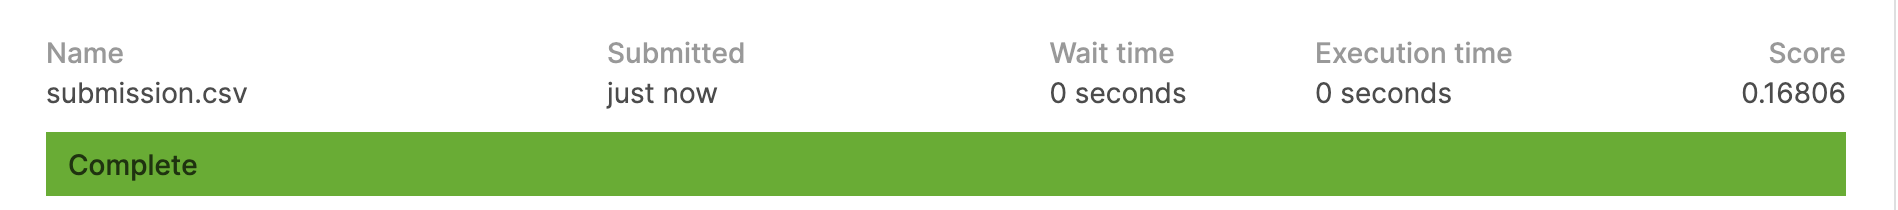

The final RMSE for the contest is 0.16806 so our estimation was really accurate.

In [25]:
#3.9 Optuna visualization
#Some visualization for the best model (KNN with optuna)
ov.plot_optimization_history(knn_optuna)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'name': 'Objective Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
              'y': [0.1834184182802463, 0.1915683293497189, 0.19965962629969025,
                    0.18564604255894615, 0.19548042041155816, 0.17932124355660986,
                    0.21214089343145673, 0.19548042041155816, 0.17993729720750262,
                    0.1887479278641862, 0.17716491260735712, 0.17708635867485897,
                    0.17716491260735712, 0.17716491260735712, 0.17823769926145944,
                    0.17802457109008007, 0.17823769926145944, 0.18357592746399404,
                    0.17805683830594643, 0.17750283764844682, 0.17708635867485897,
                    0.17708635867485897, 0.17708635867485897, 0.17932124355660986,
                    0.17708635867485897, 0.17805683830594643, 0.17750283764844682,
                    0.17955802547390753, 0.20963328626522412, 0.18325398831829404,
                    0.17802457109008007, 0.17708635867485897, 0.17823769926145944,
                    0.17708635867485897, 0.17805683830594643, 0.17716491260735712,
                    0.17907771212735307, 0.18945576168870076, 0.17835671142266468,
                    0.1887479278641862, 0.1834184182802463, 0.17708635867485897,
                    0.17708635867485897, 0.17716491260735712, 0.17802457109008007,
                    0.17823769926145944, 0.17805683830594643, 0.18778500906921985,
                    0.17716491260735712, 0.17802457109008007]},
             {'name': 'Best Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
              'y': [0.1834184182802463, 0.1834184182802463, 0.1834184182802463,
                    0.1834184182802463, 0.1834184182802463, 0.17932124355660986,
                    0.17932124355660986, 0.17932124355660986, 0.17932124355660986,
                    0.17932124355660986, 0.17716491260735712, 0.17708635867485897,
                    0.17708635867485897, 0.17708635867485897, 0.17708635867485897,
                    0.17708635867485897, 0.17708635867485897, 0.17708635867485897,
                    0.17708635867485897, 0.17708635867485897, 0.17708635867485897,
                    0.17708635867485897, 0.17708635867485897, 0.17708635867485897,
                    0.17708635867485897, 0.17708635867485897, 0.17708635867485897,
                    0.17708635867485897, 0.17708635867485897, 0.17708635867485897,
                    0.17708635867485897, 0.17708635867485897, 0.17708635867485897,
                    0.17708635867485897, 0.17708635867485897, 0.17708635867485897,
                    0.17708635867485897, 0.17708635867485897, 0.17708635867485897,
                    0.17708635867485897, 0.17708635867485897, 0.17708635867485897,
                    0.17708635867485897, 0.17708635867485897, 0.17708635867485897,
                    0.17708635867485897, 0.17708635867485897, 0.17708635867485897,
                    0.17708635867485897, 0.17708635867485897]}],
    'layout': {'template': '...',
               'title': {'text': 'Optimization History Plot'},
               'xaxis': {'title': {'text': '#Trials'}},
               'yaxis': {'title': {'text': 'Objective Value'}}}
})

The minium objective value (RMSE) is reached at the tenth iteration so the budget we have selected is by far sufficient for obtaining the best parameter tunning.

In [28]:
ov.plot_contour(knn_optuna)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'type': 'scatter', 'xaxis': 'x', 'yaxis': 'y'},
             {'colorbar': {'title': {'text': 'Objective Value'}},
              'colorscale': [[0, 'rgb(220,220,220)'], [0.30000000000000004,
                             'rgb(106,137,247)'], [0.4, 'rgb(90,120,245)'], [0.5,
                             'rgb(70,100,245)'], [0.65, 'rgb(40,60,190)'], [1,
                             'rgb(5,10,172)']],
              'connectgaps': True,
              'contours': {'coloring': 'heatmap'},
              'hoverinfo': 'none',
              'line': {'smoothing': 1.3},
              'showscale': True,
              'type': 'contour',
              'x': [0.25, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16,
                    16.75],
              'xaxis': 'x4',
              'y': [1, 2],
              'yaxis': 'y4',
              'z': [[nan, 0.20963328626522412, 0.18564604255894615,
                    0.17835671142266468, 0.17907771212735307, 0.17823769926145944,
                    0.17716491260735712, 0.17708635867485897, 0.17802457109008007,
                    0.17805683830594643, 0.17932124355660986, 0.18325398831829404,
                    0.1834184182802463, nan, nan, 0.18357592746399404, nan], [nan,
                    nan, 0.21214089343145673, 0.19965962629969025, nan, nan, nan,
                    0.18778500906921985, 0.1887479278641862, nan,
                    0.18945576168870076, nan, nan, 0.1915683293497189,
                    0.19548042041155816, nan, nan]]},
             {'marker': {'color': 'black', 'line': {'color': 'Grey', 'width': 0.5}},
              'mode': 'markers',
              'showlegend': False,
              'type': 'scatter',
              'x': [12, 13, 3, 2, 14, 10, 2, 14, 11, 8, 6, 7, 6, 6, 5, 8, 5, 16,
                    9, 4, 7, 7, 7, 10, 7, 9, 4, 7, 1, 11, 8, 7, 5, 7, 9, 6, 4, 10,
                    3, 8, 12, 7, 7, 6, 8, 5, 9, 7, 6, 8],
              'xaxis': 'x4',
              'y': [1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1,
                    1, 1, 1, 1, 1, 2, 1, 1],
              'yaxis': 'y4'},
             {'colorbar': {'title': {'text': 'Objective Value'}},
              'colorscale': [[0, 'rgb(220,220,220)'], [0.30000000000000004,
                             'rgb(106,137,247)'], [0.4, 'rgb(90,120,245)'], [0.5,
                             'rgb(70,100,245)'], [0.65, 'rgb(40,60,190)'], [1,
                             'rgb(5,10,172)']],
              'connectgaps': True,
              'contours': {'coloring': 'heatmap'},
              'hoverinfo': 'none',
              'line': {'smoothing': 1.3},
              'showscale': False,
              'type': 'contour',
              'x': [0.25, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16,
                    16.75],
              'xaxis': 'x7',
              'y': [distance, uniform],
              'yaxis': 'y7',
              'z': [[nan, 0.20963328626522412, 0.21214089343145673,
                    0.17835671142266468, 0.17750283764844682, 0.17823769926145944,
                    0.17716491260735712, 0.18778500906921985, 0.17802457109008007,
                    0.17805683830594643, 0.18945576168870076, 0.17993729720750262,
                    nan, 0.1915683293497189, nan, 0.18357592746399404, nan], [nan,
                    nan, nan, 0.19965962629969025, 0.17907771212735307, nan, nan,
                    0.17955802547390753, nan, nan, nan, 0.18325398831829404,
                    0.1834184182802463, nan, 0.19548042041155816, nan, nan]]},
             {'marker': {'color': 'black', 'line': {'color': 'Grey', 'width': 0.5}},
              'mode': 'markers',
              'showlegend': False,
              'type': 'scatter',
              'x': [12, 13, 3, 2, 14, 10, 2, 14, 11, 8, 6, 7, 6, 6, 5, 8, 5, 16,
                    9, 4, 7, 7, 7, 10, 7, 9, 4, 7, 1, 11, 8, 7, 5, 7, 9, 6, 4, 10,
                    3, 8, 12, 7, 7, 

There are not really impresing graph in terms of contour as 2 out of 3 variables are qualitative. However, we can see that if we could define a metric weight between uniform and distance we could obtain better results. For example, we could have weighted each value with a function of the inverse of its distance (distance does this with the identity) and try different values as log(), exp(), sqrt(), etc...

In [33]:
ov.plot_slice(knn_optuna)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                   14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
                                   26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
                                   38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
                         'colorbar': {'title': {'text': '#Trials'}, 'x': 1.0, 'xpad': 40},
                         'colorscale': [[0.0, 'rgb(247,251,255)'], [0.125,
                                        'rgb(222,235,247)'], [0.25,
                                        'rgb(198,219,239)'], [0.375,
                                        'rgb(158,202,225)'], [0.5,
                                        'rgb(107,174,214)'], [0.625,
                                        'rgb(66,146,198)'], [0.75,
                                        'rgb(33,113,181)'], [0.875,
                                        'rgb(8,81,156)'], [1.0, 'rgb(8,48,107)']],
                         'line': {'color': 'Grey', 'width': 0.5},
                         'showscale': True},
              'mode': 'markers',
              'showlegend': False,
              'type': 'scatter',
              'x': [12, 13, 3, 2, 14, 10, 2, 14, 11, 8, 6, 7, 6, 6, 5, 8, 5, 16,
                    9, 4, 7, 7, 7, 10, 7, 9, 4, 7, 1, 11, 8, 7, 5, 7, 9, 6, 4, 10,
                    3, 8, 12, 7, 7, 6, 8, 5, 9, 7, 6, 8],
              'xaxis': 'x',
              'y': [0.1834184182802463, 0.1915683293497189, 0.19965962629969025,
                    0.18564604255894615, 0.19548042041155816, 0.17932124355660986,
                    0.21214089343145673, 0.19548042041155816, 0.17993729720750262,
                    0.1887479278641862, 0.17716491260735712, 0.17708635867485897,
                    0.17716491260735712, 0.17716491260735712, 0.17823769926145944,
                    0.17802457109008007, 0.17823769926145944, 0.18357592746399404,
                    0.17805683830594643, 0.17750283764844682, 0.17708635867485897,
                    0.17708635867485897, 0.17708635867485897, 0.17932124355660986,
                    0.17708635867485897, 0.17805683830594643, 0.17750283764844682,
                    0.17955802547390753, 0.20963328626522412, 0.18325398831829404,
                    0.17802457109008007, 0.17708635867485897, 0.17823769926145944,
                    0.17708635867485897, 0.17805683830594643, 0.17716491260735712,
                    0.17907771212735307, 0.18945576168870076, 0.17835671142266468,
                    0.1887479278641862, 0.1834184182802463, 0.17708635867485897,
                    0.17708635867485897, 0.17716491260735712, 0.17802457109008007,
                    0.17823769926145944, 0.17805683830594643, 0.18778500906921985,
                    0.17716491260735712, 0.17802457109008007],
              'yaxis': 'y'},
             {'marker': {'color': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                   14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
                                   26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
                                   38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
                         'colorbar': {'title': {'text': '#Trials'}, 'x': 1.0, 'xpad': 40},
                         'colorscale': [[0.0, 'rgb(247,251,255)'], [0.125,
                                        'rgb(222,235,247)'], [0.25,
                                        'rgb(198,219,239)'], [0.375,
                                        'rgb(158,202,225)'], [0.5,
                                        'rgb(107,174,214)'], [0.625,
                                        'rgb(66,146,198)'], [0.75,
                                        'rgb(33,113,181)'], [0.875,
                                        'rgb(8,81,156)'], [1.0, 'rgb(8,48,107)']],
                         'line': {'color': 'Grey', 'width': 0.5},
                         'showscale': False},
              'mode': 'mar

We can see that p=1 is clearly the best option as the majority of the points with low values has this parameter. Distance is not as significant, but also performs better than uniform. Lastly, we can see that using 6 or 7 neigbors performs more or less the same, but if we try this parameters in the contest the best score is achieved with 7 neighbors

In [35]:
ov.plot_param_importances(knn_optuna)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'cliponaxis': False,
              'hovertemplate': [weights (CategoricalDistribution):
                                0.033985232346491576<extra></extra>, n_neighbors
                                (IntUniformDistribution):
                                0.39792446490791905<extra></extra>, p
                                (CategoricalDistribution):
                                0.5680903027455894<extra></extra>],
              'marker': {'color': ['rgb(66,146,198)', 'rgb(8,81,156)', 'rgb(66,146,198)']},
              'orientation': 'h',
              'text': [0.033985232346491576, 0.39792446490791905,
                       0.5680903027455894],
              'textposition': 'outside',
              'texttemplate': '%{text:.2f}',
              'type': 'bar',
              'x': [0.033985232346491576, 0.39792446490791905, 0.5680903027455894],
              'y': [weights, n_neighbors, p]}],
    'layout': {'showlegend': False,
               'template': '...',
               'title': {'text': 'Hyperparameter Importances'},
               'xaxis': {'title': {'text': 'Importance'}},
               'yaxis': {'title': {'text': 'Hyperparameter'}}}
})

Just as we have already seen, the most important parameter is P (which is equal to 1 in our best model) and the number of neighbors (which we have seen that could be 6 or 7 with equal performance). The assumptions we made regarding weights will only improve the model a bit, not a big gap in terms of RMSE will be achieved.